# MaterialPointSolver.jl Showcase 01

Author: Zenan Huo <br>
Date: 25-Aug-2024 <br>

---

This case is the 2D soil collapse test in MPM. Here we use drucker-prager to model the soil, uGIMP under MUSL update scheme is chose. You can also modify the model's preference, e.g., in the function `UserArgs2D`: 

```julia
device = :CPU,
```

You can change to `:CPU` to use CPU on your computer. To enable multi-thread mode, you have to check the threads launched by Julia:

```julia
Threads.nthreads()
```
This will show how many threads you are accessing now.

### Import Packages

In [1]:
using MaterialPointGenerator  # for pre-processing
using MaterialPointSolver
using MaterialPointVisualizer # for post-processing
using CairoMakie              # for visualization
using SysInfo                 # for querying the system information
using CUDA                    # AMDGPU, oneAPI, Metal
# make sure you already installed the required packages
active_dev = :CUDA            # :CPU, :CUDA, :ROCm, :oneAPI, :Metal
assetsdir  = MaterialPointSolver.assets_dir
sysinfo()

┌ Info: checking environment...
└ @ MaterialPointGenerator /home/zhuo/Workbench/MaterialPointGenerator.jl/src/MaterialPointGenerator.jl:33
┌ Info: embreex loaded
└ @ MaterialPointGenerator /home/zhuo/Workbench/MaterialPointGenerator.jl/src/MaterialPointGenerator.jl:57
┌ Info: checking environment...
└ @ MaterialPointVisualizer /home/zhuo/Workbench/MaterialPointVisualizer.jl/src/MaterialPointVisualizer.jl:29


Hostname: 	rtx3090
CPU(s): 	1 x Intel(R) Core(TM) i9-10900K CPU @ 3.70GHz
CPU target: 	skylake

∘ CPU 1: 
	→ 10 cores (20 CPU-threads due to 2-way SMT)
	→ 1 NUMA domain


In [2]:
# Since julia is a JIT language, the first time you run a simulation it will be slower.
# This function will run a tiny simulation in the background to `warm up` the JIT compiler.
MaterialPointSolver.warmup(Val(active_dev)) # optional

┌ Info: warming up on :CUDA [0] 🔥
└ @ MaterialPointSolverCUDAExt /home/zhuo/Workbench/MaterialPointSolver.jl/ext/CUDAExt/warmup_cuda.jl:23


In [3]:
init_grid_space_x = 0.0025
init_grid_space_y = 0.0025
init_grid_range_x = [-0.025, 0.82]
init_grid_range_y = [-0.025, 0.12]
init_mp_in_space  = 2
init_T            = 1
init_ρs           = 2650
init_ν            = 0.3
init_Ks           = 7e5
init_Es           = init_Ks * (3 * (1 - 2 * init_ν))
init_Gs           = init_Es / (2 * (1 +     init_ν))
init_ΔT           = 0.5 * init_grid_space_x / sqrt(init_Es / init_ρs)
init_step         = floor(init_T / init_ΔT / 200)
init_ϕ            = deg2rad(19.8)
init_NIC          = 9
init_basis        = :uGIMP
init_ϵ            = "FP64";

### Parameters Setup

In [4]:
args = UserArgs2D(
    Ttol         = init_T,
    Te           = 0,
    ΔT           = init_ΔT,
    time_step    = :fixed,
    FLIP         = 1,
    PIC          = 0,
    constitutive = :druckerprager,
    basis        = init_basis,
    hdf5         = false,
    hdf5_step    = init_step,
    MVL          = false,
    device       = active_dev,
    coupling     = :OS,
    scheme       = :MUSL,
    gravity      = -9.8,
    ζs           = 0,
    project_name = "2d_druckerprager",
    project_path = @__DIR__,
    ϵ            = init_ϵ
)

DeviceArgs2D:
┬────────────
├─ project name    : 2d_druckerprager
├─ project path    : /home/zhuo/Workbench/MaterialPointSolver.jl/examples/1phase1point
├─ precision       : FP64
├─ constitutive    : druckerprager
├─ basis method    : uGIMP
├─ mitigate vollock: false
└─ coupling scheme : OS


### Background Grid Setup

In [5]:
grid = UserGrid2D(
    ϵ     = init_ϵ,
    phase = 1,
    x1    = init_grid_range_x[1],
    x2    = init_grid_range_x[2],
    y1    = init_grid_range_y[1],
    y2    = init_grid_range_y[2],
    dx    = init_grid_space_x,
    dy    = init_grid_space_y,
    NIC   = init_NIC
)

DeviceGrid2D:
┬────────────
├─ phase  : 1
├─ NIC    : 9
├─ ϵ      : FP64
├─ x1 - x2: -0.025 - 0.82
├─ y1 - y2: -0.025 - 0.12
├─ dx - dy: 0.0025 - 0.0025
├─ nc     : 1.96e+04
└─ ni     : 2.00e+04


### Material Points Setup

In [6]:
dx = grid.dx / init_mp_in_space
dy = grid.dy / init_mp_in_space
ξ0 = meshbuilder(0 + dx / 2 : dx : 0.2 - dx / 2,
                 0 + dy / 2 : dy : 0.1 - dy / 2)
mp = UserParticle2D(
    ϵ     = init_ϵ,
    phase = 1,
    NIC   = init_NIC,
    dx    = dx,
    dy    = dy,
    ξ     = ξ0,
    ρs    = ones(size(ξ0, 1)) .* init_ρs
)

DeviceParticle2D:
┬────────────────
├─ phase  : 1
├─ NIC    : 9
├─ ϵ      : FP64
├─ dx - dy: 0.00125 - 0.00125
└─ np     : 1.28e+04


### Particle Property Setup

In [7]:
nid = ones(mp.np)
attr = UserProperty(
    ϵ   = init_ϵ,
    nid = nid,
    ν   = [init_ν],
    Es  = [init_Es],
    Gs  = [init_Gs],
    Ks  = [init_Ks],
    σt  = [0],
    ϕ   = [init_ϕ],
    ϕr  = [0],
    ψ   = [0],
    c   = [0],
    cr  = [0],
    Hp  = [0]
)

DeviceProperty:
┬──────────────
└─ ϵ: FP64


### Boundary Condition Nodes Index

In [8]:
vx_idx = zeros(grid.ni)
vy_idx = zeros(grid.ni)
tmp_idx = findall(i -> grid.ξ[i, 1] ≤ 0.0 || grid.ξ[i, 1] ≥ 0.8 ||
                       grid.ξ[i, 2] ≤ 0, 1:grid.ni)
tmp_idy = findall(i -> grid.ξ[i, 2] ≤ 0, 1:grid.ni)
vx_idx[tmp_idx] .= 1
vy_idx[tmp_idy] .= 1 
bc = UserVBoundary2D(
    ϵ        = init_ϵ,
    vx_s_idx = vx_idx,
    vx_s_val = zeros(grid.ni),
    vy_s_idx = vy_idx,
    vy_s_val = zeros(grid.ni)
)

DeviceVBoundary2D:
┬─────────────────
└─ ϵ: FP64


### MPM Solver

In [9]:
materialpointsolver!(args, grid, mp, attr, bc)

┌ Info: 2d_druckerprager [2D/CUDA]
│ ────────────────┬─────────────┬────────────────────
│ ΔT  : 7.02e-05s │ PIC :  0.00 │ scheme   : MUSL
│ Ttol: 1.00e+00s │ FLIP:  1.00 │ coupling : OS
│ pts : 1.28e+04  │ ζs  :  0.00 │ basis    : uGIMP
│ nds : 2.00e+04  │ ζw  :  0.00 │ precision: FP64
│ MVL :    false  │ HDF5: false │ material : D-P
│ ────────────────┴─────────────┴────────────────────
└ @ MaterialPointSolver /home/zhuo/Workbench/MaterialPointSolver.jl/src/toolkits/terminaltxt.jl:49


[▲ I/O: uploading [≈ 0.0 GiB] → :CUDA [0]


[ Info: solving 100% ■■■■■■■■■■■■  Time: 0:00:05


[▼ I/O: downloading from :CUDA [0] → host
[• I/O: free device [0] memory


┌ Info: performance
│ ────────────────────
│ wtime: 00:00:06
│ iters: 1.42e+04
│ speed: 2.44e+03 it/s
│ ────────────────────
└ @ MaterialPointSolver /home/zhuo/Workbench/MaterialPointSolver.jl/src/toolkits/terminaltxt.jl:78


### Post processing

* save to `.vtp` for ParaView:

In [10]:
savevtp(args, grid, mp, attr)

┌ Info: final vtp file is saved in project path
└ @ MaterialPointVisualizer /home/zhuo/Workbench/MaterialPointVisualizer.jl/src/mpm2vtp.jl:56


* save to `.png` and display in jupyter:

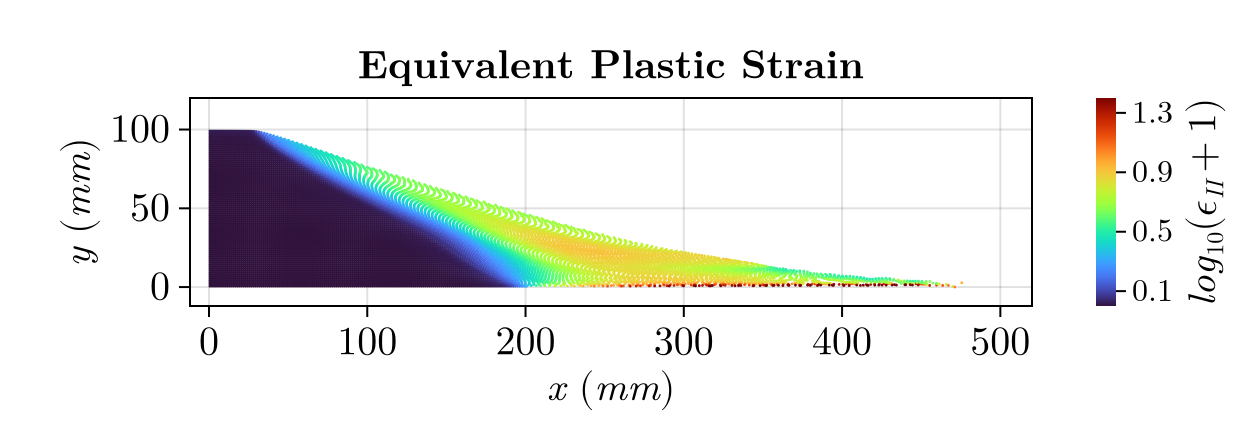

In [11]:
let
    set_theme!(theme_latexfonts())
    fig = Figure(size=(630, 220), fontsize=20)
    ax = Axis(fig[1, 1], xlabel=L"x\ (mm)", ylabel=L"y\ (mm)", aspect=DataAspect(), 
        xticks=(0:0.1:0.5, string.(collect(0:100:500))), 
        yticks=(0:0.05:0.1, string.(collect(0:50:100))), title="Equivalent Plastic Strain")
    cvalue = log10.(mp.ϵq.+1)
    p1 = scatter!(ax, mp.ξ, color=cvalue, colormap=:turbo, marker=:circle, markersize=2,
        label="Particles", colorrange=(0.0, 1.4))
    limits!(ax, -0.012, 0.52, -0.012, 0.12)
    Colorbar(fig[1, 2], p1, label=L"log_{10}(\epsilon_{II}+1)", size=10, vertical=true, 
        spinewidth=0, ticks=0.1:0.4:1.4, ticklabelsize=16)
    display(fig)
    save(joinpath(args.project_path, args.project_name, "epII.png"), fig, px_per_unit=2)
end;